# Laboratorio 6
## Data Science

Autores:

- Nelson García 
- Christian Echeverría

## Análisis de Sentimientos de críticas de películas

Junto con Keras, viene un ejemplo imdb_lstm.py. Este ejercicio esta prácticamente basado en él.

Es un gran ejemplo del uso de las RNNs.  El conjunto de datos que se utilizará consta de críticas de películas generadas por usuarios, y una classificación indicando si le gustó, o no, basado en su rating asociado. 

Hay más información de este conjunto de datos en:

https://keras.io/datasets/#imdb-movie-reviews-sentiment-classification

Como la comprensión del lenguaje escrito requiere "llevar cuenta" de todas las palabras en una oración, necesitamos una RNN para mantener una "memoria" de las palabras que pasaron antes, conforme va "leyendo" oraciones a lo largo del tiempo. 

En particular, se usarán unidades LSTM (Long Short-Term Memory) porque no es deseable "olvidar" palabras demasiado rápido...las palabras al inicio de una oración pueden afectar el significado de la misma grandemente.

Empezamos por la importación de lo que se requiere:

## Importación de Datos:

In [1]:
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"   # habilita growth desde el arranque
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"           

In [2]:
import tensorflow as tf

print("TF:", tf.__version__)
print("Build info:", getattr(tf.sysconfig, "get_build_info", lambda: {})())

gpus = tf.config.list_physical_devices('GPU')
print("GPUs detectadas:", gpus)

# Activa growth explícitamente (ya debería estar por env var, pero así confirmas)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.datasets import imdb
from tensorflow import keras
from tensorflow.keras import layers, callbacks, optimizers, regularizers


TF: 2.20.0
Build info: OrderedDict({'cpu_compiler': 'clang 18', 'cuda_compute_capabilities': ['sm_60', 'sm_70', 'sm_80', 'sm_89', 'compute_90'], 'cuda_version': '12.5.1', 'cudnn_version': '9', 'is_cuda_build': True, 'is_rocm_build': False, 'is_tensorrt_build': False})
GPUs detectadas: []


E0000 00:00:1757897729.745036  129951 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1757897729.751103  129951 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Ahora importar los datos para entrenamiento y prueba.  Para que sea más manejable, se especifica que se quieren solamente las 50,000 palabras más populares en el conjunto de datos. Por algún motivo, este conjunto tiene una relación de 50% entreno y 50% prueba. 

In [3]:
print('Cargando los datos...')
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=50000)

Cargando los datos...
17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


## Pre-procesamiento

In [4]:
len(X_train)

25000

In [5]:
len(X_test)

25000

A ver cómo son los datos, el primer elemento de entrenamiento debe ser una crítica de una película:

In [6]:
X_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 22665,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 21631,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 19193,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 10311,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 31050,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 12118,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5

Esto no parece una crítica de una película!!!!  Resulta que la gente que preparó los datos ya hizo algo de preparación previa de los datos.  Estos números coinciden con el índice correspondiente a cada palabra de la crítica.  En realidad las palabras en sí, no son de interés...el modelo requiere números no palabras. 

Lo triste es que no será posible leer las críticas...siquiera para tener una idea de si funciona el análiisis, o no.

Y, ¿cómo son las etiquetas (metas)?

In [7]:
y_train[0]

np.int64(1)

Son simplemente 0 ó 1, que indica sí al que escribió la crítica le gustó, o no, la película.

Para resumir, para el entrenamiento se tiene un conjunto de críticas de películas que han sido convertidas a vectores de palabras representadas por enteros, y una clasificación de sentimiento binaria.

Las RNNs pueden "explotar" muy rápidamente (se habló de esto en clase).  Para que no se sobrecarguen las PCs que se podrían usar, se limitarán las críticas a las primeras 80 palabras:

In [8]:
X_train = sequence.pad_sequences(X_train, maxlen = 80)
X_test = sequence.pad_sequences(X_test, maxlen = 80)

### Extracción de features adicionales

In [9]:
import nltk

try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except LookupError:
    nltk.download('vader_lexicon', quiet=True)

In [10]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.sentiment import SentimentIntensityAnalyzer


# Inicializar el analizador de sentimientos
sia = SentimentIntensityAnalyzer()

# Función para obtener características adicionales
def extract_features(texts, max_length=80):
    features = []
    
    for text in texts:
        # Convertir el índice a palabras
        word_index = imdb.get_word_index()
        index_word = {v: k for k, v in word_index.items()}
        words = [index_word.get(i - 3, '') for i in text]  # Descontamos 3 por los valores reservados (pad, start, unknown)

        # 1. Longitud de la crítica
        features.append([len(words)])
        
        # 2. Proporción de palabras positivas/negativas
        pos_words, neg_words = 0, 0
        for word in words:
            if word:
                sentiment = sia.polarity_scores(word)
                if sentiment['compound'] > 0:
                    pos_words += 1
                elif sentiment['compound'] < 0:
                    neg_words += 1
        total_words = len([word for word in words if word])  # Palabras no vacías
        pos_neg_ratio = pos_words / neg_words if neg_words > 0 else pos_words
        
        features[-1].extend([pos_words, neg_words, pos_neg_ratio])
        
        # 3. Número de palabras únicas
        unique_words = len(set(words))
        features[-1].append(unique_words)
    
    return np.array(features)

# Extraer características de entrenamiento y prueba
train_features = extract_features(X_train)
test_features = extract_features(X_test)

# Concatenar características con las etiquetas de salida (y_train y y_test)
x_train_features = np.hstack((train_features, X_train))
x_test_features = np.hstack((test_features, X_test))

# Ahora x_train_features y x_test_features tienen las características adicionales


1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## Configuración del modelo



In [11]:
vocab_size = 50000
maxlen = int(X_train.shape[1])
n_features = int(train_features.shape[1])

### Modelo Simple

In [32]:
# === MODELO SIMPLE (Baseline) ============================================================
# Secuencia -> Embedding(50k,128) -> LSTM(128) -> Sigmoid
# - Propósito: línea base rápida para comparar contra los modelos con features.
# - Entrada: X_train de forma (N, maxlen), y_train binaria {0,1}.
# - Salida: probabilidad de sentimiento positivo.

from tensorflow.keras import Sequential
from tensorflow.keras import layers, optimizers, callbacks
import tensorflow as tf

vocab_size = 50_000
maxlen = X_train.shape[1]  # asumiendo que ya hiciste padding
modelo = Sequential(name="baseline_secuencia_sola")
modelo.add(layers.Embedding(vocab_size, 128, mask_zero=True, name="embedding"))
# Nota: recurrent_dropout deshabilita CuDNN (entrenamiento más lento). Dejarlo en 0 si quieres velocidad en GPU.
modelo.add(layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2, name="lstm_128"))
modelo.add(layers.Dense(1, activation='sigmoid', name="salida"))

modelo.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', tf.keras.metrics.AUC(name="auc")]
)

# Callbacks (monitorizamos pérdida de validación: valor mínimo es mejor)
es_simple = callbacks.EarlyStopping(
    monitor='val_loss', mode='min', patience=3, restore_best_weights=True, verbose=1
)
rlr_simple = callbacks.ReduceLROnPlateau(
    monitor='val_loss', mode='min', factor=0.5, patience=2, min_lr=1e-6, verbose=1
)

historia = modelo.fit(
    X_train, y_train,
    batch_size=64,
    epochs=15,
    validation_split=0.2,      # <- mejor que usar directamente el conjunto de test
    callbacks=[es_simple, rlr_simple],
    verbose=1
)

# Guardado y recarga (opcional)
modelo.save("Analisis_Sentimiento.keras")
from tensorflow.keras.models import load_model
modelo = load_model("Analisis_Sentimiento.keras")

# Evaluación en test
perdida, exactitud, auc_ = modelo.evaluate(X_test, y_test, batch_size=64, verbose=2)
print(f"Pérdida (test): {perdida:.4f} | Accuracy: {exactitud:.4f} | AUC: {auc_:.4f}")


Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 118ms/step - accuracy: 0.7824 - auc: 0.8639 - loss: 0.4631 - val_accuracy: 0.8310 - val_auc: 0.9153 - val_loss: 0.3867 - learning_rate: 0.0010
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 114ms/step - accuracy: 0.8882 - auc: 0.9504 - loss: 0.2828 - val_accuracy: 0.8082 - val_auc: 0.8927 - val_loss: 0.4160 - learning_rate: 0.0010
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9364 - auc: 0.9782 - loss: 0.1824
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 114ms/step - accuracy: 0.9281 - auc: 0.9752 - loss: 0.1959 - val_accuracy: 0.8236 - val_auc: 0.9011 - val_loss: 0.4415 - learning_rate: 0.0010
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 114ms/step - accuracy: 0.9603 - auc: 0.9903 - loss: 0.1179 - val_accuracy: 0.8260 - val_auc: 0.9034 - val_loss: 0.5058 - learning_rate: 5.0000e-04
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1

In [13]:
modelo.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Modelo con features

In [33]:
# === MODELO CON FEATURES (Rama de texto + Rama numérica) =================================
# - Entrada 1: secuencia (tokens) -> Embedding -> LSTM
# - Entrada 2: features numéricas -> Normalization -> Dense(32, relu)
# - Fusión -> Dense(64) -> Dropout -> Sigmoid
# - Motivo: las features globales (longitud, OOV, polaridad) complementan la señal secuencial.

from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks, optimizers
import tensorflow as tf

n_features = train_features.shape[1]

# Normalización de features dentro del grafo (evita fugas de datos)
normalizador = layers.Normalization(axis=-1, name="normalizador_features")
normalizador.adapt(train_features)  # adaptar SIEMPRE con datos de entrenamiento

# Entrada 1: secuencia
inp_seq_1 = layers.Input(shape=(maxlen,), name="input_secuencia")
x1 = layers.Embedding(input_dim=vocab_size, output_dim=128, mask_zero=True, name="embedding")(inp_seq_1)
x1 = layers.LSTM(64, name="lstm_64")(x1)  # (recurrent_dropout=0 acelera con CuDNN)

# Entrada 2: features
inp_feat_1 = layers.Input(shape=(n_features,), name="input_features")
f1 = normalizador(inp_feat_1)
f1 = layers.Dense(32, activation="relu", name="feat_dense_32")(f1)

# Fusión de ramas
h1 = layers.Concatenate(name="concat")([x1, f1])
h1 = layers.Dense(64, activation="relu", name="post_concat_dense_64")(h1)
h1 = layers.Dropout(0.5, name="dropout_05")(h1)

# Salida
out_1 = layers.Dense(1, activation="sigmoid", name="salida")(h1)

modelo_basico = keras.Model(inputs=[inp_seq_1, inp_feat_1], outputs=out_1, name="modelo_lstm_basico")
modelo_basico.compile(
    optimizer=optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=[keras.metrics.AUC(name="auc"), "accuracy"]
)

# Callbacks (aquí probamos monitorizar AUC: valor máximo es mejor)
early_stop = callbacks.EarlyStopping(
    monitor="val_auc", mode="max", patience=3, restore_best_weights=True, verbose=1
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss", mode="min", factor=0.5, patience=2, min_lr=1e-6, verbose=1
)

history_basico = modelo_basico.fit(
    [X_train, train_features], y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1,
)

modelo_basico.save("Analisis_Sentimiento2.keras")
perdida, AUC, exactitud = modelo_basico.evaluate([X_test, test_features], y_test, batch_size=64, verbose=2)
print(f"Pérdida (test): {perdida:.4f} | Accuracy: {exactitud:.4f} | AUC: {AUC:.4f}")


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 87ms/step - accuracy: 0.7901 - auc: 0.8702 - loss: 0.4505 - val_accuracy: 0.8380 - val_auc: 0.9206 - val_loss: 0.3635 - learning_rate: 0.0010
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - accuracy: 0.9086 - auc: 0.9653 - loss: 0.2368 - val_accuracy: 0.8330 - val_auc: 0.9184 - val_loss: 0.3701 - learning_rate: 0.0010
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9601 - auc: 0.9906 - loss: 0.1174
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.9550 - auc: 0.9894 - loss: 0.1244 - val_accuracy: 0.8240 - val_auc: 0.9066 - val_loss: 0.5145 - learning_rate: 0.0010
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.9857 - auc: 0.9980 - loss: 0.0468 - val_accuracy: 0.8238 - val_auc: 0.8968 - val_loss: 0.6608 - learning_rate: 5.0000e-04
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
391

### Modelo mejorado

In [34]:
# === MODELO AVANZADO (BiLSTM apiladas + regularización) =================================
# - SpatialDropout1D para robustez a "apagado" por canal
# - BiLSTM (return_sequences=True) + BiLSTM final
# - MLP más profundo en la rama de features
# - Regularización L2 y Dropout en la fusión

from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks, optimizers
import tensorflow as tf

inp_seq_2 = layers.Input(shape=(maxlen,), name="input_secuencia_avanzado")

# Rama de texto avanzada
x2 = layers.Embedding(input_dim=vocab_size, output_dim=256, mask_zero=True, name="embedding_avanzado")(inp_seq_2)
x2 = layers.SpatialDropout1D(0.2, name="spatial_dropout")(x2)
x2 = layers.Bidirectional(
        layers.LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
        name="bilstm_128_rs"
     )(x2)
x2 = layers.Dropout(0.3, name="dropout_seq_03")(x2)
x2 = layers.Bidirectional(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2), name="bilstm_64")(x2)
x2 = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-4), name="text_dense_64")(x2)

# Rama de features avanzada
inp_feat_2 = layers.Input(shape=(n_features,), name="input_features_avanzado")
f2 = normalizador(inp_feat_2)
f2 = layers.Dense(64, activation="relu", name="feat_dense_64")(f2)
f2 = layers.Dropout(0.3, name="feat_dropout_03")(f2)
f2 = layers.Dense(32, activation="relu", name="feat_dense_32_b")(f2)

# Fusión
h2 = layers.Concatenate(name="concat_avanzado")([x2, f2])
h2 = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4), name="fusion_dense_128")(h2)
h2 = layers.Dropout(0.5, name="fusion_dropout_05")(h2)
h2 = layers.Dense(64, activation="relu", name="fusion_dense_64")(h2)

out_2 = layers.Dense(1, activation="sigmoid", name="salida_avanzada")(h2)

modelo_avanzado = keras.Model(inputs=[inp_seq_2, inp_feat_2], outputs=out_2, name="modelo_lstm_avanzado")
modelo_avanzado.compile(
    optimizer=optimizers.Adam(3e-4),
    loss="binary_crossentropy",
    metrics=[keras.metrics.AUC(name="auc"), "accuracy"]
)

history_avanzado = modelo_avanzado.fit(
    [X_train_, train_features], y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

modelo_avanzado.save("Analisis_Sentimiento3.keras")
perdida, AUC, exactitud = modelo_avanzado.evaluate([X_test_, test_features], y_test, batch_size=64, verbose=2)
print(f"Pérdida (test): {perdida:.4f} | Accuracy: {exactitud:.4f} | AUC: {AUC:.4f}")


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 136s 405ms/step - accuracy: 0.7430 - auc: 0.8243 - loss: 0.5316 - val_accuracy: 0.8346 - val_auc: 0.9164 - val_loss: 0.3852 - learning_rate: 3.0000e-04
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.8838 - auc: 0.9467 - loss: 0.3093
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
313/313 ━━━━━━━━━━━━━━━━━━━━ 126s 402ms/step - accuracy: 0.8824 - auc: 0.9468 - loss: 0.3089 - val_accuracy: 0.8422 - val_auc: 0.9230 - val_loss: 0.3728 - learning_rate: 3.0000e-04
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 125s 399ms/step - accuracy: 0.9420 - auc: 0.9812 - loss: 0.1826 - val_accuracy: 0.8418 - val_auc: 0.9215 - val_loss: 0.4330 - learning_rate: 1.5000e-04
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.9618 - auc: 0.9905 - loss: 0.1286
Epoch 4: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
313/313 ━━━━━━━━━━━━━━━━━━━━ 123s 393ms/step - accuracy: 0.9589 - auc: 0.9900 -

## Informe

,modelo,accuracy,f1,auc
0,Sólo secuencia,0.83336,0.842935,0.916636
1,Secuencia + features (simple),0.83876,0.837138,0.918490
2,Secuencia + features (avanzado),0.83996,0.840018,0.919838


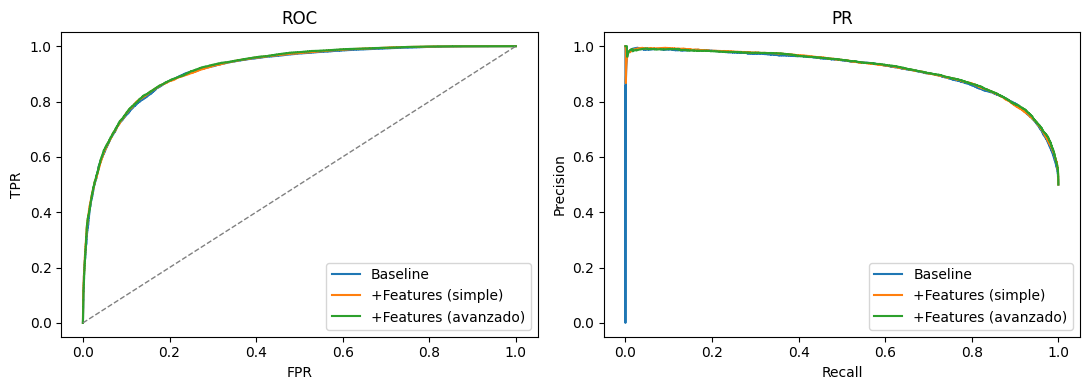

In [36]:
# === PRESENTACIÓN: tabla comparativa + curvas ROC/PR =====================================
import pandas as pd
from sklearn.metrics import f1_score, precision_recall_curve, roc_curve, auc

def eval_model(model, X, y_true):
    y_prob = model.predict(X, verbose=0).ravel()
    y_pred = (y_prob >= 0.5).astype(int)
    acc = (y_pred == y_true).mean().item()
    f1 = f1_score(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_roc = auc(fpr, tpr)
    prec, rec, _ = precision_recall_curve(y_true, y_prob)
    return {"accuracy": acc, "f1": f1, "auc": auc_roc}, (fpr, tpr), (rec, prec)

res = []
m_base, roc_base, pr_base = eval_model(modelo, X_test, y_test)
res.append({"modelo":"Sólo secuencia", **m_base})
m_plus, roc_plus, pr_plus = eval_model(modelo_basico, [X_test, test_features], y_test)
res.append({"modelo":"Secuencia + features (simple)", **m_plus})
m_adv, roc_adv, pr_adv = eval_model(modelo_avanzado, [X_test_, test_features], y_test)
res.append({"modelo":"Secuencia + features (avanzado)", **m_adv})

display(pd.DataFrame(res))

# Curvas ROC/PR
import matplotlib.pyplot as plt
plt.figure(figsize=(11,4))
plt.subplot(1,2,1)
for (lbl, (fpr,tpr)) in [
    ("Baseline", roc_base),
    ("+Features (simple)", roc_plus),
    ("+Features (avanzado)", roc_adv),
]:
    plt.plot(fpr, tpr, label=lbl)
plt.plot([0,1],[0,1],'--',lw=1, c='gray')
plt.title("ROC"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()

plt.subplot(1,2,2)
for (lbl, (rec,prec)) in [
    ("Baseline", pr_base),
    ("+Features (simple)", pr_plus),
    ("+Features (avanzado)", pr_adv),
]:
    plt.plot(rec, prec, label=lbl)
plt.title("PR"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()
plt.tight_layout(); plt.show()


### Resultados

Resultados. Trabajamos con IMDB (50 k vocabulario) y una línea base LSTM sobre secuencia, comparándola con dos variantes que añaden una rama de features (longitud, OOV, polaridad). En test, el baseline obtiene Acc = 0.833, F1 = 0.843, AUC = 0.917. Al añadir features, el modelo simple sube a Acc = 0.839 (+0.54 pp) y AUC = 0.918 (+0.0019), mientras que el avanzado alcanza Acc = 0.840 (+0.66 pp) y AUC = 0.920 (+0.0032). En F1, las variantes con features quedan muy cerca del baseline (0.837 y 0.840 frente a 0.843). Las curvas ROC/PR se solapan casi por completo, con una leve ventaja de los modelos con features especialmente en el rango de recall medio–alto.

### Discusión

Las features aportan una mejor calibración/ranking (AUC ligeramente superior) y una pequeña mejora en accuracy, pero el umbral fijo de 0.5 no maximiza F1; esto explica que F1 no suba pese a la mejor AUC. En otras palabras, el modelo ordena mejor los ejemplos (más separabilidad), pero requiere ajuste del umbral (p. ej., max-F1 o Youden-J en validación) para traducir esa ganancia en F1. La versión avanzada (BiLSTM + regularización) es la mejor global y muestra entrenamiento estable (early stopping + reduce-LR). En conjunto, se cumple el objetivo del laboratorio: la integración de features mejora de forma modesta pero consistente al baseline, y deja claro el siguiente paso práctico: tuning del umbral, ampliar el set de features (negaciones/intensificadores) y/o embeddings preentrenados para empujar F1 sin sacrificar AUC.